# SVM

Test Preds files fromat :
Name : fold_0_biobert-v1.1_BCE_with_title_run-0_opt_neg-500 if there is title fold_0_biobert-v1.1_BCE_run-0_opt_neg-500 if not
columns : label,prediction,score,fold,title

one file for the results of one model on one folds

<Figure size 640x480 with 0 Axes>

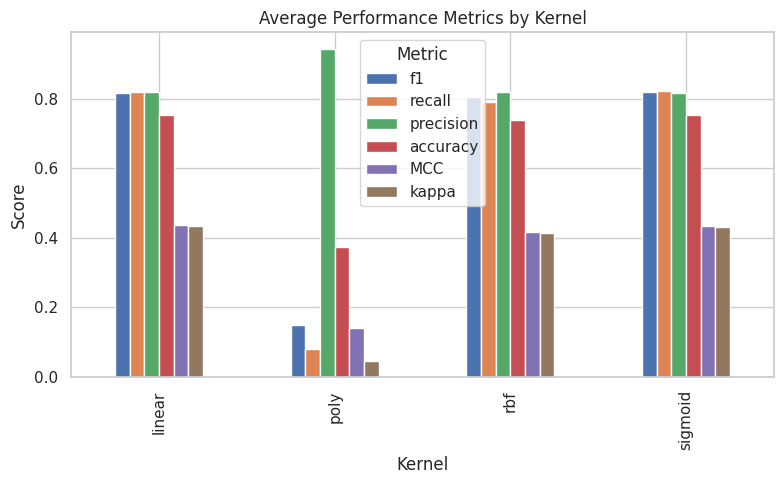

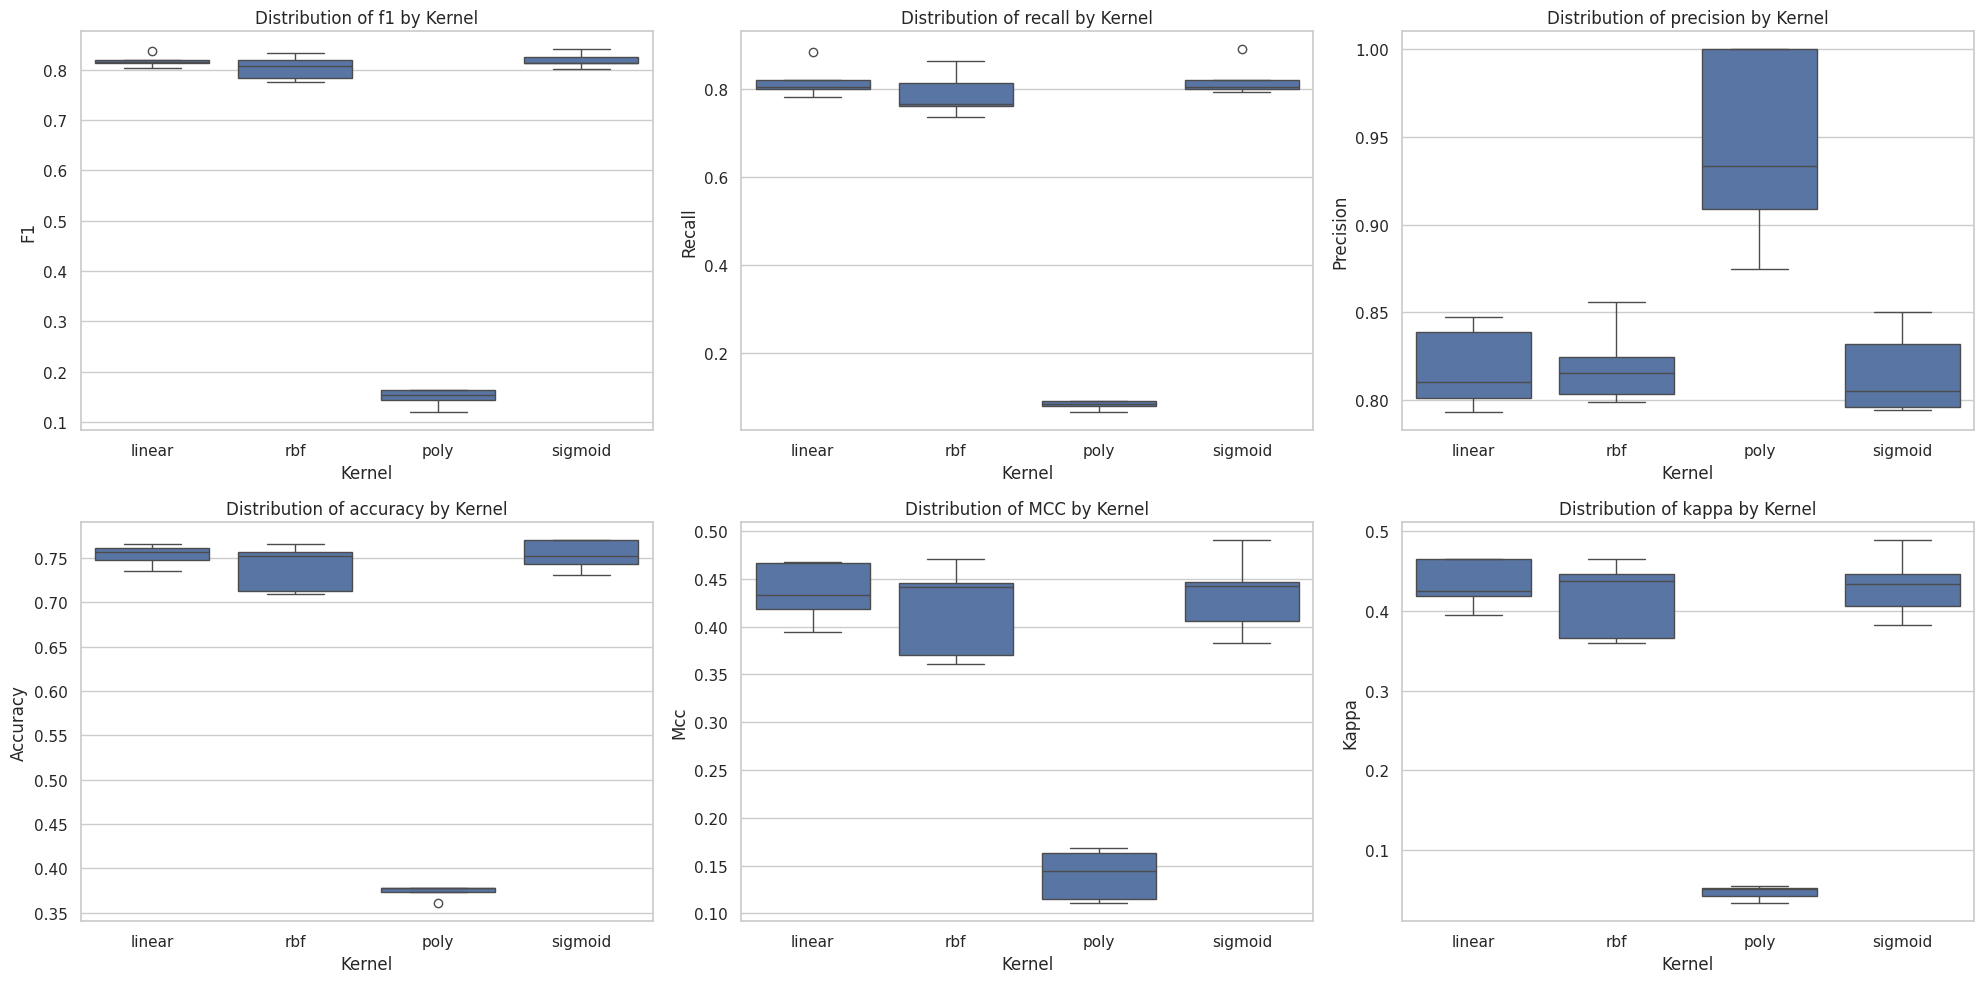

<Figure size 640x480 with 0 Axes>

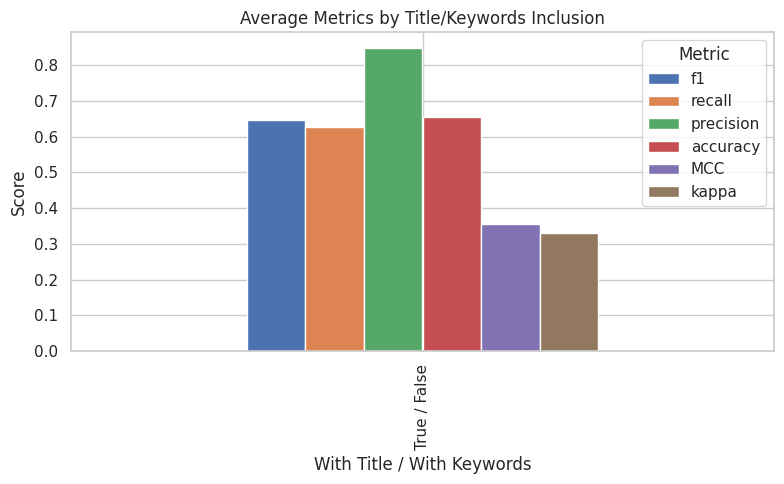

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
svm_df = pd.read_csv('/home/leandre/Projects/BioMoQA_Playground/results/metrics/svm_metrics.csv')
svm_df = svm_df.drop(columns=['model_name'])

# 1. Mean metrics by kernel
mean_by_kernel =svm_df.groupby('kernel')[['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']].mean()

plt.figure()
mean_by_kernel.plot(kind='bar', figsize=(8, 5))
plt.title('Average Performance Metrics by Kernel')
plt.ylabel('Score')
plt.xlabel('Kernel')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# 2. Boxplot of each metric by kernel
metrics = ['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']
# For each metric, plot BCE vs focal for each model
num_metrics = len(metrics)
n_cols = 3
n_rows = (num_metrics + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax=axes[i]
    data_to_plot = [svm_df[svm_df['kernel'] == k][metric] for k in svm_df['kernel'].unique()]
    sns.boxplot(data=svm_df,x='kernel',y=metric,ax=ax)
    ax.set_title(f'Distribution of {metric} by Kernel')
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel('Kernel')
plt.tight_layout()
plt.show()

# 3. Mean metrics by with_title and with_keywords combinations
svm_df['title_keywords'] = svm_df['with_title'].astype(str) + ' / ' + svm_df['with_keywords'].astype(str)
mean_by_combo = svm_df.groupby('title_keywords')[['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']].mean()

plt.figure()
mean_by_combo.plot(kind='bar', figsize=(8, 5))
plt.title('Average Metrics by Title/Keywords Inclusion')
plt.ylabel('Score')
plt.xlabel('With Title / With Keywords')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


# Random Forest

<Figure size 640x480 with 0 Axes>

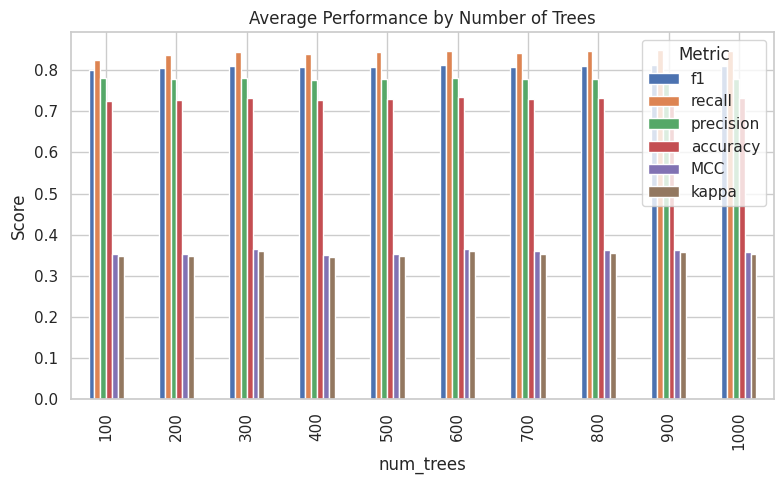

<Figure size 640x480 with 0 Axes>

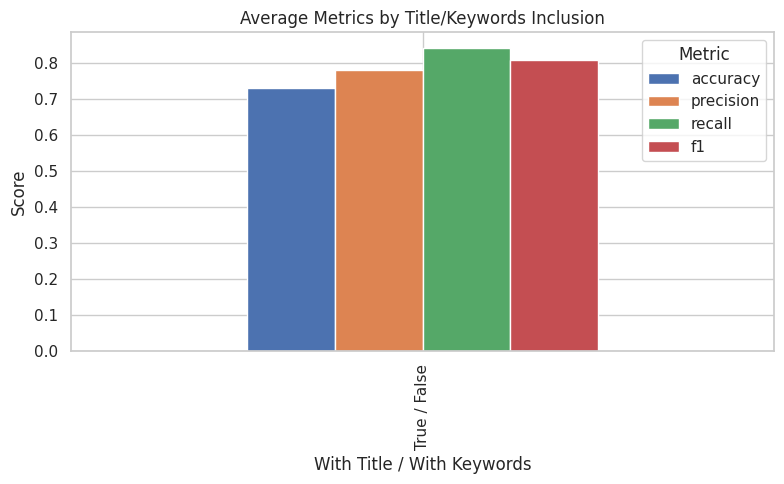

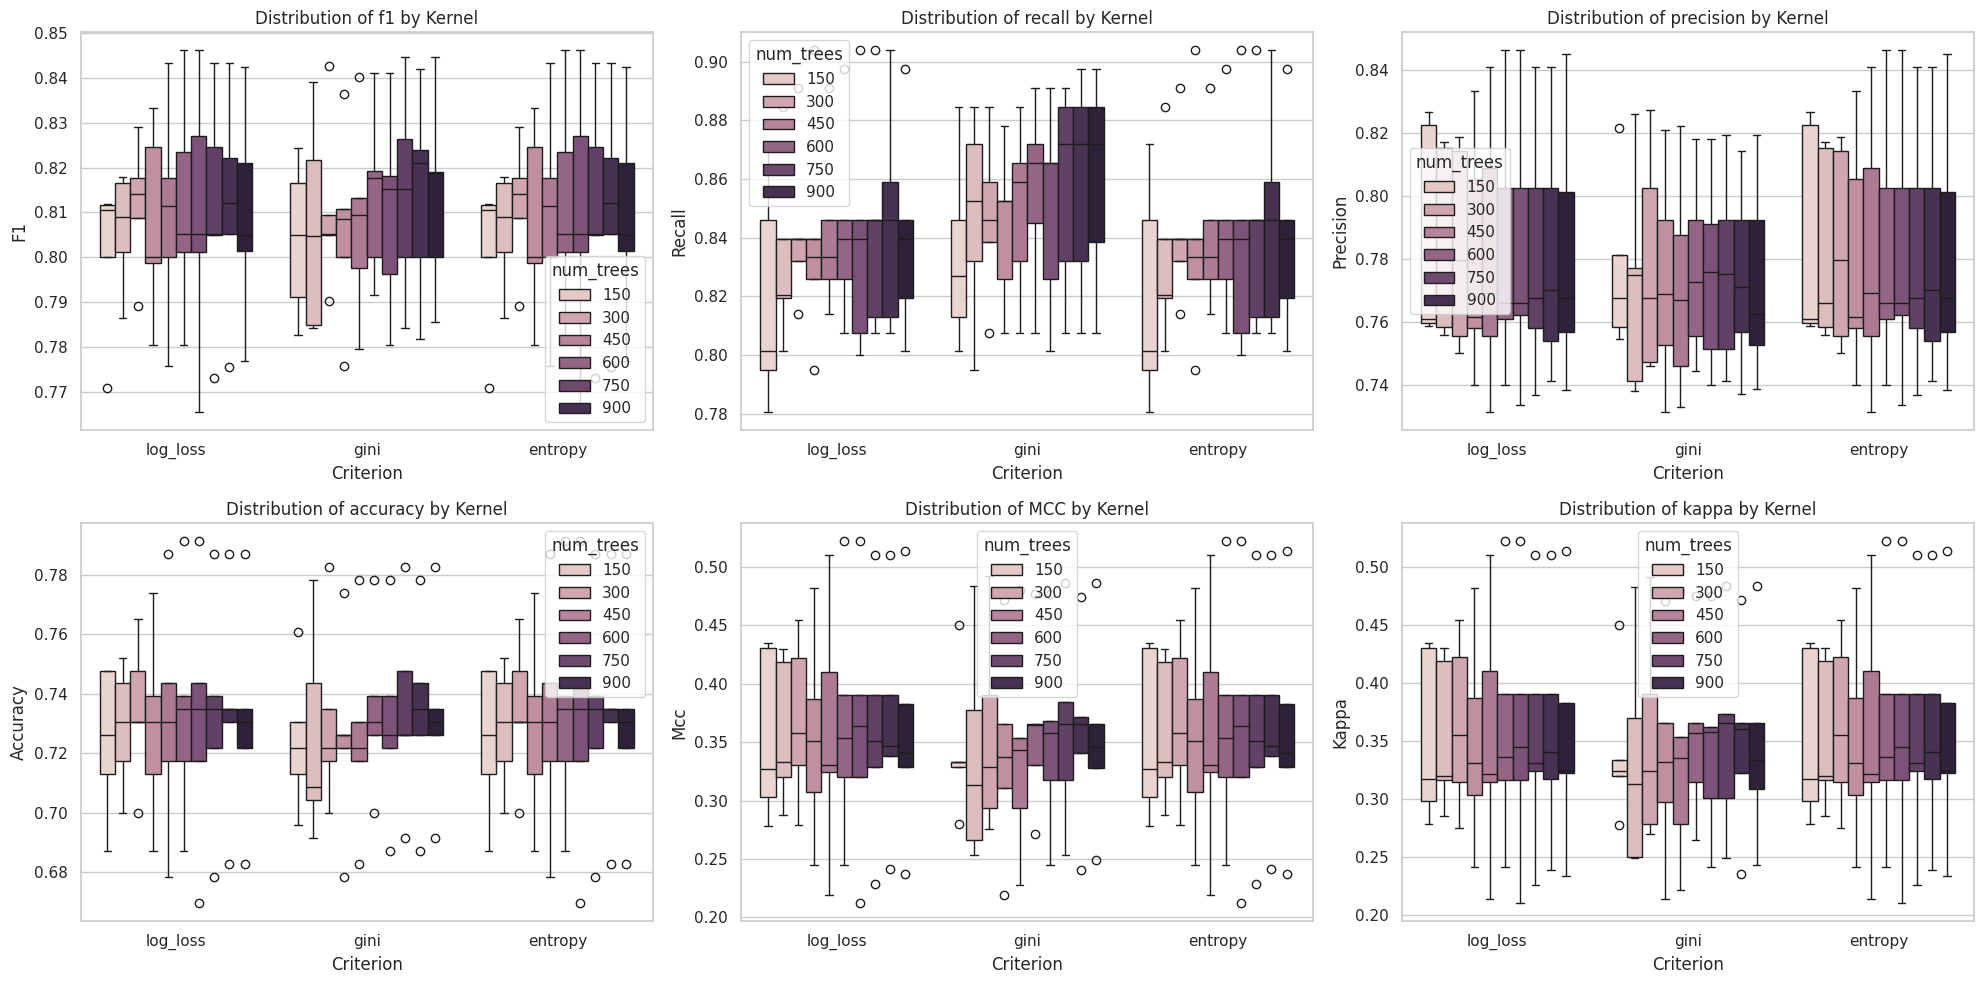

<Figure size 640x480 with 0 Axes>

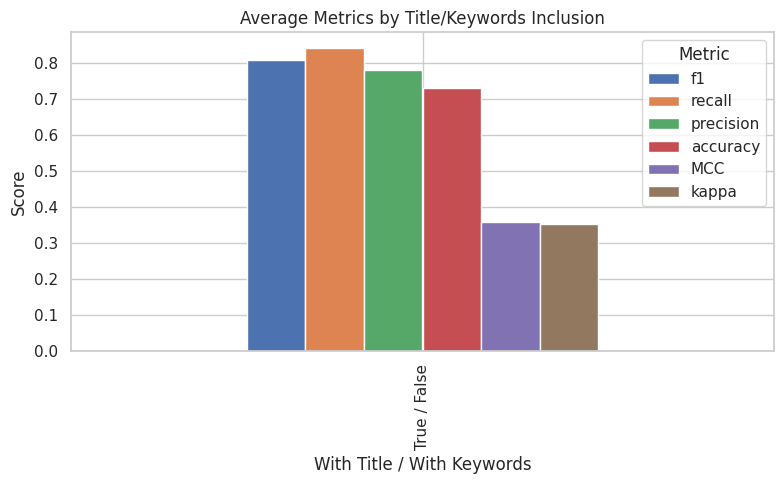

In [133]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare the data
rf_df = pd.read_csv('/home/leandre/Projects/BioMoQA_Playground/results/metrics/random_forest_metrics.csv')
rf_df = rf_df.drop(columns=['model_name'])

import matplotlib.pyplot as plt
metrics=['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']
# 1. Average metrics by num_trees
mean_by_trees = rf_df.groupby('num_trees')[['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']].mean()
plt.figure()
mean_by_trees.plot(kind='bar', figsize=(8, 5))
plt.title('Average Performance by Number of Trees')
plt.ylabel('Score')
plt.xlabel('num_trees')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# 3. Average metrics by Title/Keywords combination
rf_df['title_keywords'] = rf_df['with_title'].astype(str) + ' / ' + rf_df['with_keywords'].astype(str)
mean_by_combo = rf_df.groupby('title_keywords')[['accuracy', 'precision', 'recall', 'f1']].mean()
plt.figure()
mean_by_combo.plot(kind='bar', figsize=(8, 5))
plt.title('Average Metrics by Title/Keywords Inclusion')
plt.ylabel('Score')
plt.xlabel('With Title / With Keywords')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

num_metrics = len(metrics)
n_cols = 3
n_rows = (num_metrics + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax=axes[i]
    sns.boxplot(data=rf_df,x='criterion',y=metric,hue='num_trees',ax=ax)
    ax.set_title(f'Distribution of {metric} by Kernel')
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel('Criterion')
plt.tight_layout()
plt.show()

# 3. Mean metrics by with_title and with_keywords combinations
rf_df['title_keywords'] = rf_df['with_title'].astype(str) + ' / ' + rf_df['with_keywords'].astype(str)
mean_by_combo = rf_df.groupby('title_keywords')[['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']].mean()

plt.figure()
mean_by_combo.plot(kind='bar', figsize=(8, 5))
plt.title('Average Metrics by Title/Keywords Inclusion')
plt.ylabel('Score')
plt.xlabel('With Title / With Keywords')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## BERT

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '/home/leandre/Projects/BioMoQA_Playground/results/metrics/binary_metrics.csv'
bert_df = pd.read_csv(file_path)
bert_df_title=bert_df[bert_df['with_title']==True]
bert_df_abs = bert_df[bert_df['with_title']==False]
bert_df=bert_df_abs

# Filter out 'focal' and 'BCE' subsets
df_bce = bert_df_title[bert_df_title['loss_type'] == 'BCE']
df_focal = bert_df_title[bert_df_title['loss_type'] == 'focal']

# Define metric columns to aggregate
metric_cols = ['f1', 'recall', 'precision', 'accuracy', 'AP', 'MCC', 'NDCG', 'kappa']

# Aggregate metrics by model_name for BCE
agg_bce = df_bce.groupby('model_name')[metric_cols].mean().reset_index()

# Aggregate metrics by model_name for focal
agg_focal = df_focal.groupby('model_name')[metric_cols].mean().reset_index()

# Function to plot grouped bar chart and line profile for a given aggregated DataFrame
def plot_metrics(aggregated_df, title_suffix):
    models = aggregated_df['model_name']
    metrics = metric_cols
    x_positions = range(len(models))
    
    # Grouped Bar Chart
    plt.figure(figsize=(10, 5))
    bar_width = 0.1
    for i, metric in enumerate(metrics):
        plt.bar([pos + bar_width * i for pos in x_positions], aggregated_df[metric], width=bar_width, label=metric)
    plt.xticks([pos + bar_width * (len(metrics) - 1) / 2 for pos in x_positions], models, rotation=45)
    plt.xlabel('Model Name')
    plt.ylabel('Average Metric Value')
    plt.title(f'Grouped Bar Chart of Average Metrics ({title_suffix})')
    plt.legend(fontsize='small', ncol=2)
    plt.tight_layout()
    
    # Line Plot
    x_pos_metrics = range(len(metrics))
    plt.figure(figsize=(10, 5))
    for idx, model in enumerate(models):
        y_vals = aggregated_df.iloc[idx][metrics]
        plt.plot(x_pos_metrics, y_vals, marker='o', label=model)
    plt.xticks(x_pos_metrics, metrics, rotation=45)
    plt.xlabel('Metric')
    plt.ylabel('Average Metric Value')
    plt.title(f'Metric Profile Across Models ({title_suffix})')
    plt.legend(fontsize='small')
    plt.tight_layout()




## BERT

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

naive_df = pd.read_csv('/home/leandre/Projects/BioMoQA_Playground/results/metrics/naive_metrics.csv')

naive_df = naive_df[naive_df['approach'] != 'always neg']

# === Settings ===
sns.set_theme(style='whitegrid')
metric_cols = ['f1', 'recall', 'precision', 'accuracy', 'AP', 'MCC', 'NDCG', 'kappa']

# === Ensure numeric metrics ===
for df in [bert_df_title, svm_df, rf_df, naive_df]:
    for col in metric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# === Add consistent columns to all dataframes ===
bert_df_title['model'] = 'BERT'
svm_df['model'] = 'SVM'
rf_df['model'] = 'RF'
naive_df['model'] = 'Naive'

bert_df_title['loss_type'] = bert_df_title['loss_type'].astype(str)
svm_df['loss_type'] = 'N/A'
rf_df['loss_type'] = 'N/A'
naive_df['loss_type'] = 'N/A'

# For consistent plotting, assign model_name if missing
svm_df['model_name'] = 'SVM'
rf_df['model_name'] = 'RF'
naive_df['model_name'] = naive_df['approach']

# === Concatenate all runs ===
all_runs = pd.concat([bert_df_title, svm_df, rf_df, naive_df], ignore_index=True)


In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, Dropdown, RadioButtons


metric_cols = ['f1','recall','precision','accuracy','roc_auc','AP','MCC','NDCG','kappa','TN','FP','FN','TP']

for df in [bert_df_title,bert_df_abs, svm_df, rf_df, naive_df]:
    for col in metric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

svm_df['model'] = 'SVM'
rf_df['model'] = 'RF'
naive_df['model'] = 'Naive'

bert_df_title['loss_type'] = bert_df_title['loss_type'].astype(str)
bert_df_abs['loss_type'] = bert_df_abs['loss_type'].astype(str)
svm_df['loss_type'] = 'Baseline'
rf_df['loss_type'] = 'Baseline'
naive_df['loss_type'] = 'Naive'


svm_df['model_name'] = 'SVM'
rf_df['model_name'] = 'RF'
naive_df['model_name'] = naive_df['approach']



baselines=pd.concat([svm_df, rf_df, naive_df], ignore_index=True)

print(all_runs[(all_runs['model_name'] != 'SVM') & (all_runs['model_name'] != 'RF') & (all_runs['fold'] == 0)])


# For each metric, plot BCE vs focal for each model
num_metrics = len(metric_cols)
n_cols = 2
n_rows = 2
folds = sorted(all_runs['fold'].unique())
print(folds)
print(folds[0])

# interactive plot
@interact(
    metric=Dropdown(options=metric_cols, description="Metric:"),
    with_title=Dropdown(options=['with_title', 'without_title'], description="With Title:"),
    view=RadioButtons(options=['Subplots','Distribution'], description="View:")
)
def plot_metric(metric,with_title, view):
    data = bert_df_title if with_title=='with_title' else bert_df_abs
    print(data['loss_type'].unique())
    max_baselines=baselines.iloc[[ baselines[baselines['fold']==f][metric].idxmax() for f in baselines['fold'].unique()]]
    max_baselines['model_name'] = 'Best Baseline'
    max_baselines['loss_type'] = 'Baseline'
    data=pd.concat([data,max_baselines])
    sns.set_theme(style='whitegrid')
    folds = sorted(data['fold'].unique())
    model_names = list(data['model_name'].unique()) if metric != "roc_auc" and metric != "AP" and metric!='NDCG' else [m for m in all_runs['model_name'].unique() if m not in ['SVM', 'RF', 'always pos']]
    if 'Ensemble' in model_names:
        model_names = [m for m in model_names if m != 'Ensemble']
        model_names.insert(5, 'Ensemble')
    model_order = model_names
    
    if view == 'Subplots':
        # one barplot per fold
        n = len(folds)
        ncols = 2
        nrows = (n + 1)//2
        fig, axes = plt.subplots(nrows, ncols, figsize=(14, 5*nrows))
        axes = axes.flatten()

        for i in range(len(folds)):
            fold = folds[i]
            ax = axes[i]
            sns.barplot(
                data= data[data['fold']==fold] if metric != "roc_auc" and metric != "AP" and metric!='NDCG' else data[(data['model_name'] != 'SVM') and (data['model_name'] != 'RF') and (data['model_name'] != 'always pos') and (data['fold'] == fold)],
                x='model_name', y=metric, hue='loss_type', ax=ax,order=model_order
            )
            ax.set_xlabel("Model Name")
            ax.tick_params(axis='x', rotation=45)
            ax.set_title(f"{metric.upper()} (fold {fold})")
            ax.set_ylabel(metric)
            ax.grid(axis='y', linestyle='--', alpha=0.5)
            ax.legend(fontsize='small')
        
        # remove any extra axes
        for j in range(len(folds), len(axes)):
            fig.delaxes(axes[j])
        
        plt.tight_layout()
        plt.show()
    
    else:
        # single boxplot across folds
        plt.figure(figsize=(12,6))
        # Get unique model_names, move 'Ensemble' to the 6th position if present
        sns.boxplot(
            data=data if metric != "roc_auc" and metric != "AP" and metric!='NDCG' else data[(data['model_name'] != 'SVM') & (data['model_name'] != 'RF') & (data['model_name'] != 'always pos')],
            x='model_name', y=metric, hue='loss_type', order=model_order
        )
        plt.title(f"{metric.upper()} distribution across folds")
        plt.xticks(rotation=45)
        plt.xlabel("Model Name")
        plt.ylabel(metric)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.legend(title='Loss type', fontsize='small')
        plt.tight_layout()
        plt.show()

Empty DataFrame
Columns: [model_name, loss_type, fold, run, with_title, with_keywords, nb_added_negs, num_trials, hpo_metric, f1, recall, precision, accuracy, roc_auc, AP, MCC, NDCG, kappa, TN, FP, FN, TP, model, kernel, title_keywords, criterion, num_trees, approach]
Index: []

[0 rows x 28 columns]
[1, 2, 3, 4, 5]
1


interactive(children=(Dropdown(description='Metric:', options=('f1', 'recall', 'precision', 'accuracy', 'roc_a…

In [137]:
import os
import sys
import glob
import logging
from sklearn.metrics import f1_score


logger = logging.getLogger(__name__)

src_dir = os.path.abspath(os.path.join("/home/leandre/Projects/BioMoQA_Playground/src/.."))

# Add it to sys.path
if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.config import *
from src.utils import plot_roc_curve,plot_precision_recall_curve


DATA_DIR = '/home/leandre/Projects/BioMoQA_Playground/results/test preds'

best_svm=svm_df.groupby(['kernel','with_title','with_keywords','nb_added_negs'])["f1"].mean().reset_index()
best_svm = best_svm.sort_values(by='f1', ascending=False).head(1)
print('Best SVM parameters:')
print(best_svm[['kernel', 'with_title', 'with_keywords', 'nb_added_negs']])
# 1) LOAD CSVs PER MODEL TYPE & FOLD
model_data = {}
for model_type in ["bert","svm"]:
    all_files = glob.glob(os.path.join(DATA_DIR, model_type, '*.csv'))
    for fpath in all_files:
        # unify column names
        if model_type == "svm":
            df.rename(columns={'score': 'prediction'}, inplace=True)
            model_name = os.path.basename(fpath).replace('.csv', '')
            splitted_name = model_name.split('_')
            if splitted_name[1]==best_svm['kernel'].iloc[0] and ('title' in splitted_name if best_svm['with_title'].iloc[0] else not 'title' in splitted_name ) and ("neg-"+str(best_svm['nb_added_negs'].iloc[0]) in splitted_name):
                df = pd.read_csv(fpath)
                df.rename(columns={'score': 'prediction'}, inplace=True)
                print(f"Loading SVM model: {model_name} with best parameters")
                model_data["best_svm"]=[df[df["fold"] == i] for i in df["fold"].unique()]
        elif model_type == "bert":
            df = pd.read_csv(fpath)
            fname=os.path.basename(fpath).replace('.csv', '')
            model_name = fname[7:]
            model_data.setdefault(model_name, []).append(df[df["fold"] == int(fname[5])])
        elif model_type == "rf":
            df = pd.read_csv(fpath)
            fname=fname=os.path.basename(fpath).replace('.csv', '')
            model_name = fname[7:]
            model_data.setdefault(model_name, []).append(df[df["fold"] == int(fname[5])])

@interact(
    model_name=Dropdown(options=model_data.keys(), description="Models:"),
)
def plot_roc_curves(model_name):
    dfs= model_data[model_name]
    all_folds_df = pd.concat(dfs, ignore_index=True)
    plot_roc_curve(all_folds_df['label'],all_folds_df['score'],logger=logger, plot_dir=CONFIG["plot_dir"],store_plot=False)



Best SVM parameters:
    kernel  with_title  with_keywords  nb_added_negs
3  sigmoid        True          False            500
Loading SVM model: svm_sigmoid_with_title_run-0_opt_neg-500 with best parameters


interactive(children=(Dropdown(description='Models:', options=('bert-base-uncased_BCE_with_title_run-0_opt_neg…

# Statistical Test

## Friedman + Nemenyi

In [138]:
import numpy as np
from scipy.stats import norm

# Example fold results
metric = 'roc_auc'
metrics_dict={}
for model in bert_df['model_name'].unique():
    fold_results = bert_df[bert_df['model_name'] == model][metric]
    metrics_dict[model]=fold_results.tolist()
k = len(metrics_dict)

for model in metrics_dict:
    metrics= metrics_dict[model]
    # Compute statistics
    mean_recall = np.mean(metrics)
    std_recall = np.std(metrics, ddof=1)  # use ddof=1 for sample std
    se = std_recall / np.sqrt(k)

    # 95% confidence interval
    z = norm.ppf(0.975)  # two-tailed 95% CI
    ci_lower = mean_recall - z * se
    ci_upper = mean_recall + z * se

    print(f"Mean {metric} for model {model} accross folds : {mean_recall:.3f}")
    print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]\n")




Mean roc_auc for model BiomedBERT-abs accross folds : 0.894
95% CI: [0.879, 0.909]

Mean roc_auc for model BiomedBERT-abs-ft accross folds : 0.898
95% CI: [0.885, 0.912]

Mean roc_auc for model roberta-base accross folds : 0.884
95% CI: [0.858, 0.910]

Mean roc_auc for model biobert-v1 accross folds : 0.891
95% CI: [0.872, 0.911]

Mean roc_auc for model bert-base accross folds : 0.891
95% CI: [0.870, 0.911]

Mean roc_auc for model Ensemble accross folds : 0.915
95% CI: [0.904, 0.926]



In [139]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from sklearn.metrics import f1_score,roc_auc_score
import matplotlib.pyplot as plt

#print(model_data)
# 2) COMPUTE F1 PER FOLD
perf = {}
for model_name, dfs in model_data.items():
    f1s = [roc_auc_score(d['label'], d['score']) if 'label' in d and 'score' in d else f1_score(d['label'], d['prediction']) for d in dfs]
    if len(f1s)==5 :
        perf[model_name] = f1s
if not perf:
    raise ValueError("No performance data found—check your DATA_DIR!")
print(perf)
# Build DataFrame (folds × models)
n_folds = len(next(iter(perf.values())))
fold_idx = list(range(1, n_folds + 1))
perf_df = pd.DataFrame(perf, index=fold_idx)

# 3) FRIEDMAN TEST
stat, p = friedmanchisquare(*[perf_df[col] for col in perf_df.columns])
print(f"Friedman χ² = {stat:.3f}, p = {p:.4f}")
if p >= 0.05:
    print("→ Not significant; stop here.")
else:
    print("→ Significant; running Nemenyi post‑hoc...\n")
    nemenyi_pvals = sp.posthoc_nemenyi_friedman(perf_df)
    #print("Pairwise Nemenyi p‑values:\n", nemenyi_pvals.round(4))

    # 4) CRITICAL‑DIFFERENCE DIAGRAM
    ranks_df = perf_df.rank(axis=1,ascending=False)
    avg_ranks = ranks_df.mean(axis=0)
    plt.figure(figsize=(20, 5))
    plt.title("Critical Difference Diagram (α = 0.05)")
    # Create significance matrix: True if p < 0.05, else False
    sig_matrix = nemenyi_pvals < 0.05
    print("begin critical difference diagram")
    sp.critical_difference_diagram(avg_ranks.to_dict(), sig_matrix)
    print("Critical Difference Diagram plotted successfully.")
    plt.tight_layout()
    plt.show()
    


{'bert-base-uncased_BCE_with_title_run-0_opt_neg-500': [0.9271483021483021, 0.9144144144144144, 0.9122487872487873, 0.8935913978494624, 0.9164934164934165], 'roberta-base_BCE_with_title_run-0_opt_neg-500': [0.9081774081774081, 0.9083010752688173, 0.8847453222453223, 0.900987525987526, 0.9123354123354123], 'Ensemble_focal_run-0_opt_neg-500': [0.9204781704781705, 0.8966562716562716, 0.9196985446985447, 0.9332986832986834, 0.9046881720430108], 'biobert-v1.1_BCE_run-0_opt_neg-500': [0.9108817204301075, 0.8470200970200971, 0.8997747747747749, 0.8834892584892585, 0.8931046431046431], 'BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext_BCE_with_title_run-0_opt_neg-500': [0.8686763686763687, 0.9251559251559252, 0.9119139784946237, 0.9090869715869716, 0.8675502425502426], 'Ensemble_BCE_with_title_run-0_opt_neg-500': [0.933763440860215, 0.9216909216909217, 0.9238565488565489, 0.9233367983367984, 0.9262820512820512], 'bert-base-uncased_BCE_run-0_opt_neg-500': [0.9120755370755371, 0.8935053763440

In [140]:
print(perf)

{'bert-base-uncased_BCE_with_title_run-0_opt_neg-500': [0.9271483021483021, 0.9144144144144144, 0.9122487872487873, 0.8935913978494624, 0.9164934164934165], 'roberta-base_BCE_with_title_run-0_opt_neg-500': [0.9081774081774081, 0.9083010752688173, 0.8847453222453223, 0.900987525987526, 0.9123354123354123], 'Ensemble_focal_run-0_opt_neg-500': [0.9204781704781705, 0.8966562716562716, 0.9196985446985447, 0.9332986832986834, 0.9046881720430108], 'biobert-v1.1_BCE_run-0_opt_neg-500': [0.9108817204301075, 0.8470200970200971, 0.8997747747747749, 0.8834892584892585, 0.8931046431046431], 'BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext_BCE_with_title_run-0_opt_neg-500': [0.8686763686763687, 0.9251559251559252, 0.9119139784946237, 0.9090869715869716, 0.8675502425502426], 'Ensemble_BCE_with_title_run-0_opt_neg-500': [0.933763440860215, 0.9216909216909217, 0.9238565488565489, 0.9233367983367984, 0.9262820512820512], 'bert-base-uncased_BCE_run-0_opt_neg-500': [0.9120755370755371, 0.8935053763440

In [141]:
import pandas as pd
import numpy as np
import autorank
import matplotlib.pyplot as plt
import seaborn as sns

original_models = perf_df.columns.tolist()
perf_df.head()

,bert-base-uncased_BCE_with_title_run-0_opt_neg-500,roberta-base_BCE_with_title_run-0_opt_neg-500,Ensemble_focal_run-0_opt_neg-500,biobert-v1.1_BCE_run-0_opt_neg-500,BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext_BCE_with_title_run-0_opt_neg-500,Ensemble_BCE_with_title_run-0_opt_neg-500,bert-base-uncased_BCE_run-0_opt_neg-500,biobert-v1.1_focal_run-0_opt_neg-500,BiomedNLP-BiomedBERT-base-uncased-abstract_BCE_with_title_run-0_opt_neg-500,roberta-base_focal_run-0_opt_neg-500,roberta-base_BCE_run-0_opt_neg-500,Ensemble_BCE_run-0_opt_neg-500,BiomedNLP-BiomedBERT-base-uncased-abstract_BCE_run-0_opt_neg-500,BiomedNLP-BiomedBERT-base-uncased-abstract_focal_run-0_opt_neg-500,BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext_BCE_run-0_opt_neg-500,BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext_focal_run-0_opt_neg-500,biobert-v1.1_BCE_with_title_run-0_opt_neg-500,bert-base-uncased_focal_run-0_opt_neg-500
1,0.927148,0.908177,0.920478,0.910882,0.868676,0.933763,0.912076,0.893333,0.896700,0.875520,0.912946,0.930700,0.901117,0.894108,0.886968,0.907961,0.890376,0.855484
2,0.914414,0.908301,0.896656,0.847020,0.925156,0.921691,0.893505,0.897263,0.893798,0.904712,0.919006,0.914414,0.905968,0.896310,0.891979,0.887821,0.905579,0.851698
3,0.912249,0.884745,0.919699,0.899775,0.911914,0.923857,0.892412,0.914328,0.931183,0.807656,0.889813,0.889293,0.908903,0.902027,0.872574,0.880344,0.924817,0.919872
4,0.893591,0.900988,0.933299,0.883489,0.909087,0.923337,0.925069,0.922037,0.918399,0.878638,0.856722,0.920911,0.920478,0.879764,0.924203,0.899168,0.898345,0.903456
5,0.916493,0.912335,0.904688,0.893105,0.867550,0.926282,0.876906,0.853344,0.862266,0.897436,0.893971,0.918538,0.872055,0.859667,0.914458,0.917966,0.911383,0.876992


In [142]:
def get_model_family(model_name):
    model_name = model_name.lower()
    if 'ensemble' in model_name:
        return 'Ensemble'
    if 'roberta' in model_name:
        return 'RoBERTa'
    if 'biomedbert-base-uncased-abstract-fulltext' in model_name:
        return 'BiomedBERT-AF'
    if 'biomedbert' in model_name:
        return 'BiomedBERT-A'
    if 'biobert' in model_name:
        return 'BioBERT'
    if 'bert-base-uncased' in model_name:
        return 'BERT'
    return 'Other'

def abbreviate_name(model_name):
    family = get_model_family(model_name)
    
    if family == 'BiomedBERT-AF':
        label = 'BiomedBERT-AF'
    elif family == 'BiomedBERT-A':
        label = 'BiomedBERT-A'
    else:
        label = family
        
    if 'BCE' in model_name:
        label += ' +BCE'
    elif 'focal' in model_name:
        label += ' +FL'
        
    if 'with_title' in model_name:
        label += ' +T'
    if 'opt_neg-1000' in model_name:
        label += ' (N1k)'
    elif 'opt_neg-500' in model_name:
        label += ' (N500)'
        
    return label

def get_color_map(model_names):
    palette = {
        'Ensemble': '#5e3c99', # Purple
        'RoBERTa': '#2c7fb8',   # Blue
        'BiomedBERT-A': '#fdb863', # Light Orange
        'BiomedBERT-AF': '#e66101', # Dark Orange
        'BioBERT': '#c51b7d',   # Pink/Red
        'BERT': '#4dac26'       # Green
    }
    
    color_map = {}
    for name in model_names:
        family = get_model_family(name)
        if family in palette:
            color_map[abbreviate_name(name)] = palette[family]
    return color_map


abbreviated_models = [abbreviate_name(m) for m in original_models]
perf_df.columns = abbreviated_models
color_map = get_color_map(original_models)


abbreviation_key = pd.DataFrame({
    'Abbreviated Name': abbreviated_models,
    'Original Name': original_models
})
abbreviation_key

,Abbreviated Name,Original Name
0,BERT +BCE +T (N500),bert-base-uncased_BCE_with_title_run-0_opt_neg...
1,RoBERTa +BCE +T (N500),roberta-base_BCE_with_title_run-0_opt_neg-500
2,Ensemble +FL (N500),Ensemble_focal_run-0_opt_neg-500
3,BioBERT +BCE (N500),biobert-v1.1_BCE_run-0_opt_neg-500
4,BiomedBERT-AF +BCE +T (N500),BiomedNLP-BiomedBERT-base-uncased-abstract-ful...
5,Ensemble +BCE +T (N500),Ensemble_BCE_with_title_run-0_opt_neg-500
6,BERT +BCE (N500),bert-base-uncased_BCE_run-0_opt_neg-500
7,BioBERT +FL (N500),biobert-v1.1_focal_run-0_opt_neg-500
8,BiomedBERT-A +BCE +T (N500),BiomedNLP-BiomedBERT-base-uncased-abstract_BCE...
9,RoBERTa +FL (N500),roberta-base_focal_run-0_opt_neg-500


                              meanrank      mean       std ci_lower ci_upper  \
RoBERTa +FL (N500)                13.8  0.872792  0.038440      NaN      NaN   
BiomedBERT-A +FL (N500)           13.4  0.886375  0.017033      NaN      NaN   
BioBERT +BCE (N500)               12.4  0.886854  0.024400      NaN      NaN   
BERT +FL (N500)                   12.2  0.881500  0.029748      NaN      NaN   
BiomedBERT-AF +FL (N500)          11.2  0.898652  0.015103      NaN      NaN   
BiomedBERT-AF +BCE (N500)         11.0  0.898036  0.020987      NaN      NaN   
BioBERT +FL (N500)                10.4  0.896061  0.026656      NaN      NaN   
BiomedBERT-AF +BCE +T (N500)      10.0  0.896477  0.026596      NaN      NaN   
RoBERTa +BCE (N500)                9.8  0.894492  0.024445      NaN      NaN   
BiomedBERT-A +BCE +T (N500)        9.8  0.900469  0.026377      NaN      NaN   
BERT +BCE (N500)                   9.4  0.899994  0.018758      NaN      NaN   
BiomedBERT-A +BCE (N500)           9.4  

TypeError: 'Axes' object is not subscriptable

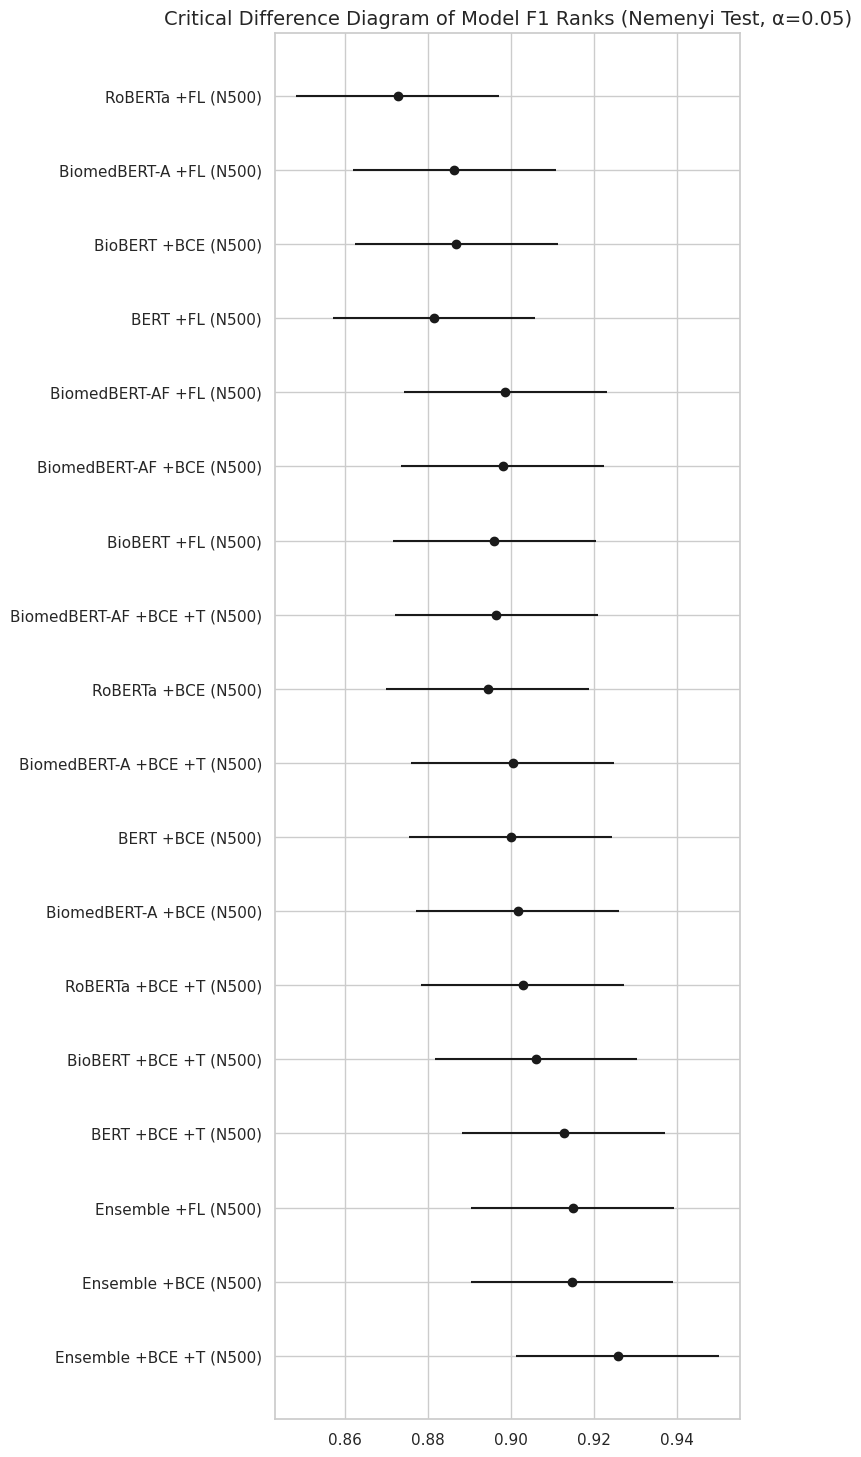

In [143]:

result = autorank.autorank(perf_df, alpha=0.05, verbose=False)


fig = autorank.plot_stats(result)


plt.title('Critical Difference Diagram of Model F1 Ranks (Nemenyi Test, α=0.05)', fontsize=14)
fig.axes[0].set_xlabel('Average Rank based on F1 Score', fontsize=12)
fig.tight_layout()
plt.savefig('../reports/cd_plot_main_improved.png', dpi=300)
plt.show()

In [ ]:


perf_df.columns = original_models


mean_scores = perf_df.mean().reset_index()
mean_scores.columns = ['model', 'mean_f1']
mean_scores['family'] = mean_scores['model'].apply(get_model_family)


best_models_per_family = mean_scores.loc[mean_scores.groupby('family')['mean_f1'].idxmax()]
best_model_names = best_models_per_family['model'].tolist()


best_of_family_df = perf_df[best_model_names]


best_of_family_df.columns = [abbreviate_name(m) for m in best_model_names]
best_of_family_color_map = get_color_map(best_model_names)



result_best_family = autorank.autorank(best_of_family_df, alpha=0.05, verbose=False)
fig_best_family = autorank.plot_stats(result_best_family, 
                                      fig_size=(8, 4),
                                      color_map=best_of_family_color_map)

plt.title('CD Plot of Best Performing Model from Each Family', fontsize=14)
fig_best_family.axes[0].set_xlabel('Average Rank based on F1 Score', fontsize=12)
fig_best_family.tight_layout()
plt.savefig('../reports/cd_plot_best_family.png', dpi=300)
plt.show()